<a href="https://colab.research.google.com/github/Oaybarf/FX/blob/main/Prueba_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from datetime import datetime
import pytz

# Definir la zona horaria de Perú
timezone = pytz.timezone("America/Lima")

# Obtener la fecha y hora actual en Perú
current_time_peru = datetime.now(timezone)

# Crear un DataFrame con la fecha y hora actual
data = {
    "Fecha": [current_time_peru.strftime("%Y-%m-%d")],
    "Hora": [current_time_peru.strftime("%H:%M:%S")]
}

df = pd.DataFrame(data)
print(df)

        Fecha      Hora
0  2024-10-02  17:10:35


In [2]:
%%capture
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

[*********************100%***********************]  1 of 1 completed

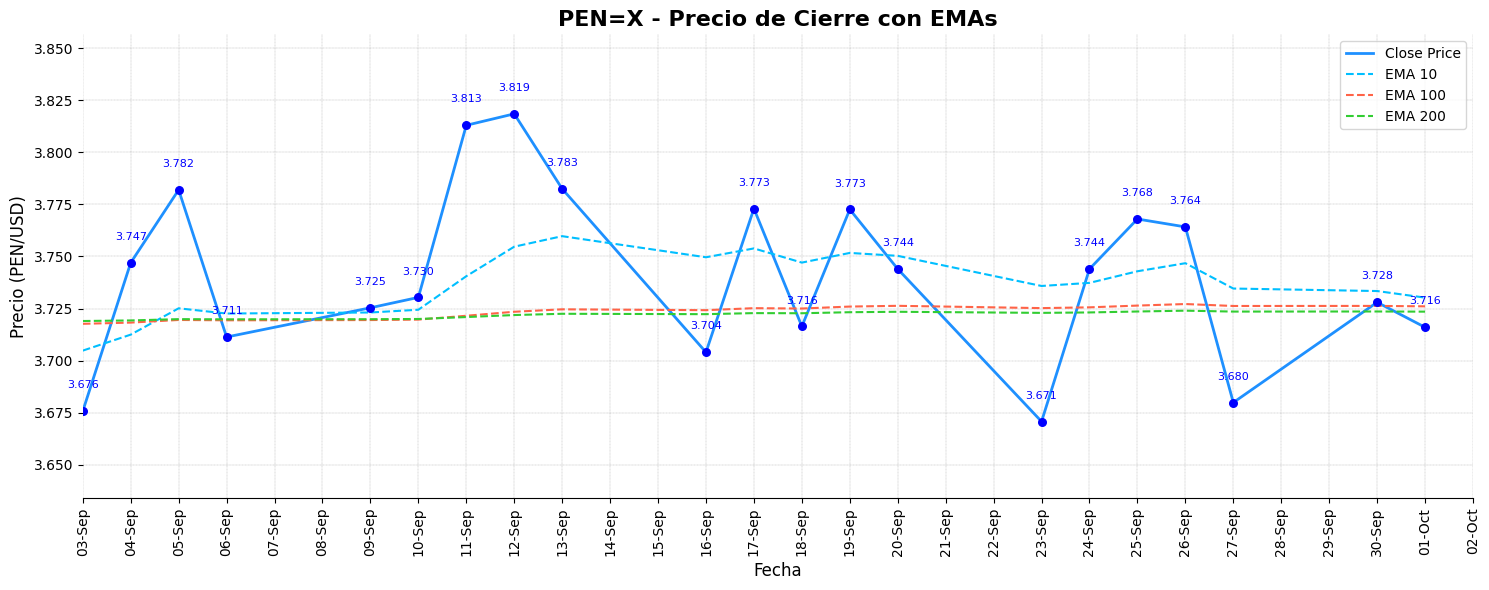

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import talib as ta
import matplotlib.dates as mdates


stock_symbol = 'PEN=X' # USD
# stock_symbol = 'VSAT' # VIASAT

stock_data = yf.download(stock_symbol,  period="max")

# Create a Date column
stock_data['Date'] = stock_data.index

# Drop the Date as index
stock_data.reset_index(drop=True, inplace=True)

dt_all = pd.date_range(start=stock_data.index[0],end=stock_data.index[-1])

dt_obs = [d.strftime("%Y-%m-%d") for d in pd.to_datetime(stock_data.index)]

dt_breaks = [d for d in dt_all.strftime("%Y-%m-%d").tolist() if not d in dt_obs]

# 1. EMA 10, 20, 50
# --------------------------------------------
stock_data['EMA10'] = stock_data['Close'].ewm(span=10, min_periods=10, adjust=False).mean()
stock_data['EMA20'] = stock_data['Close'].ewm(span=20, min_periods=20, adjust=False).mean()
stock_data['EMA50'] = stock_data['Close'].ewm(span=50, min_periods=50, adjust=False).mean()
stock_data['EMA100'] = stock_data['Close'].ewm(span=100, min_periods=100, adjust=False).mean()
stock_data['EMA200'] = stock_data['Close'].ewm(span=200, min_periods=200, adjust=False).mean()

# 2. MACD values
# --------------------------------------------
stock_data['macd'], stock_data['macdSignal'], stock_data['macdHist'] = ta.MACD(stock_data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
stock_data['macddiff1'] = stock_data['macd'].shift(1) - stock_data['macdSignal'].shift(1)
stock_data['macddiff-1'] = stock_data['macd'].shift(-1) - stock_data['macdSignal'].shift(-1)


# Filtrar datos para los últimos 6 meses
six_months_ago = pd.to_datetime('today') - pd.DateOffset(months=1)
stock_data = stock_data[stock_data['Date'] >= six_months_ago]


# Eliminar filas con fechas no válidas
stock_data = stock_data.dropna(subset=['Close', 'EMA10', 'EMA100', 'EMA200'])

# Graficar el precio de cierre y EMAs
plt.figure(figsize=(15, 6))

# Graficar precios de cierre como líneas
plt.plot(stock_data['Date'], stock_data['Close'], color='#1E90FF', label='Close Price', linewidth=2, linestyle='-')

# Graficar EMAs
plt.plot(stock_data['Date'], stock_data['EMA10'], color='#00BFFF', label='EMA 10', linewidth=1.5, linestyle='--')
plt.plot(stock_data['Date'], stock_data['EMA100'], color='#FF6347', label='EMA 100', linewidth=1.5, linestyle='--')
plt.plot(stock_data['Date'], stock_data['EMA200'], color='#32CD32', label='EMA 200', linewidth=1.5, linestyle='--')

# Agregar puntos y etiquetas para el precio de cierre
plt.scatter(stock_data['Date'], stock_data['Close'], color='blue', s=30, zorder=5)  # Puntos para el precio de cierre

# Usar iterrows() para iterar sobre las filas
for index, row in stock_data.iterrows():
    plt.text(row['Date'], row['Close']+ 0.01, f"{row['Close']:.3f}",
             fontsize=8, ha='center', color='blue', verticalalignment='bottom')

# Personalizar el gráfico
plt.title(f"{stock_symbol} - Precio de Cierre con EMAs", fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio (PEN/USD)', fontsize=12)
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.2)

# Ajustar formato de fecha en el eje x para que muestre solo los días hábiles
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())  # Mostrar todos los días
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))  # Formato de fecha ddmmm

# Ajustar límites de los ejes
plt.xlim(stock_data['Date'].min(), stock_data['Date'].max() + pd.DateOffset(days=1))  # Ajustar el eje X
plt.ylim(bottom=stock_data['Close'].min()*0.99, top=stock_data['Close'].max() * 1.01)  # Ajustar el eje Y

# Ocultar los bordes superior y laterales
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xticks(rotation=90)  # Rotar las etiquetas de los días para mejor legibilidad
plt.tight_layout()  # Ajustar el diseño

# Guardar el gráfico como archivo PNG
plt.savefig('historical_close_price.png')  # Guardar en el directorio actual

# Mostrar el gráfico
plt.show()